In [1]:
# Class dependencies
from model import OrigamiNetwork
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import pickle


# Other analysis libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from sklearn.datasets import load_digits

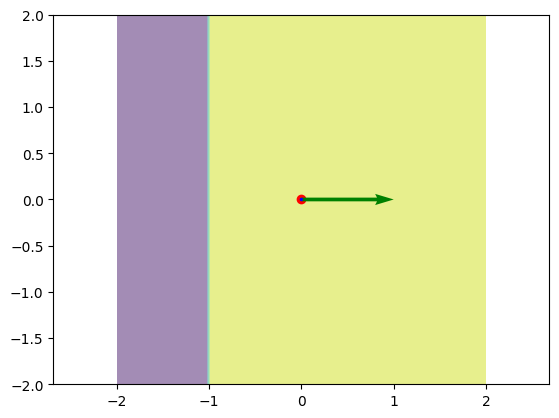

[[0.26894142 0.2769591  0.28512257 ... 0.94878705 0.95071507 0.95257413]
 [0.26894142 0.2769591  0.28512257 ... 0.94878705 0.95071507 0.95257413]
 [0.26894142 0.2769591  0.28512257 ... 0.94878705 0.95071507 0.95257413]
 ...
 [0.26894142 0.2769591  0.28512257 ... 0.94878705 0.95071507 0.95257413]
 [0.26894142 0.2769591  0.28512257 ... 0.94878705 0.95071507 0.95257413]
 [0.26894142 0.2769591  0.28512257 ... 0.94878705 0.95071507 0.95257413]]
0.9525741268224333


In [56]:
# make a random matrix of integers
cut = np.array([[1,0],[0,0]])
b = np.array([1,0])

size = 3
xmin = -size
xmax = size
ymin = -size
ymax = size
# make a grid for a decision boundary
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)

# make a grid for a decision boundary
Z = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        vector = np.array([X[i,j], Y[i,j]])
        vals = np.exp(cut @ vector + b)
        final = vals[0] / np.sum(vals)
        Z[i,j] = final
        
# plot the decision boundary
Z_mask = Z > 0.5
Z_mask = Z_mask.astype(int)
plt.contourf(X, Y, Z_mask, alpha=0.5)
plt.scatter(0, 0, color='red')
plt.axis('equal')
# plot the vectors of cut
plt.quiver(0, 0, cut[0,0], cut[0,1], angles='xy', scale_units='xy', scale=1, color='green')
plt.quiver(0, 0, cut[1,0], cut[1,1], angles='xy', scale_units='xy', scale=1, color='blue')
plt.show()
print(Z)
print(np.max(Z))




Epoch 298/300 - Train Acc: 1.0000 - Val Acc: 0.9618: 100%|██████████| 300/300 [00:07<00:00, 38.44it/s]


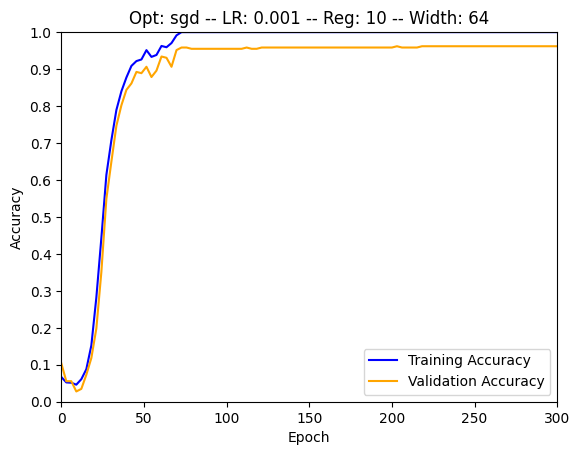

0.9583333333333334


In [2]:
# import small digits dataset

digits = load_digits()
X = digits.data
y = digits.target

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# set up the model
model = OrigamiNetwork(layers=1, epochs=300, optimizer='sgd',learning_rate=0.001, sigmoid=False, crease=5)
model.fit(X_train, y_train, X_val, y_val)

# get the predictions
y_hat = model.predict(X_test)
print(accuracy_score(y_test, y_hat))


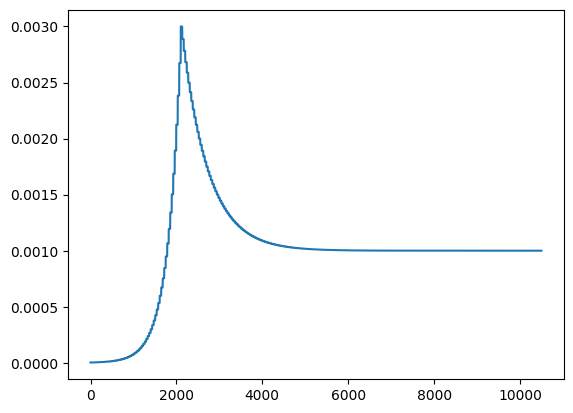

In [25]:
plt.plot(model.learning_rate_history)
plt.show()

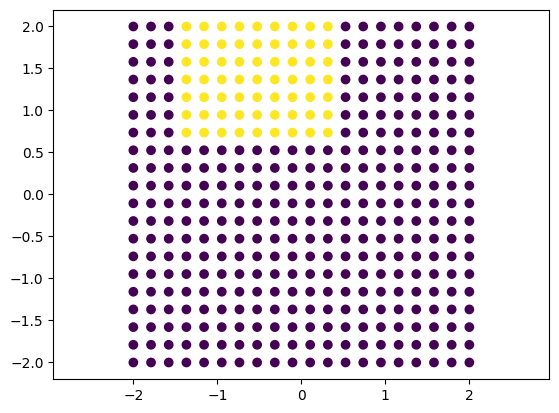

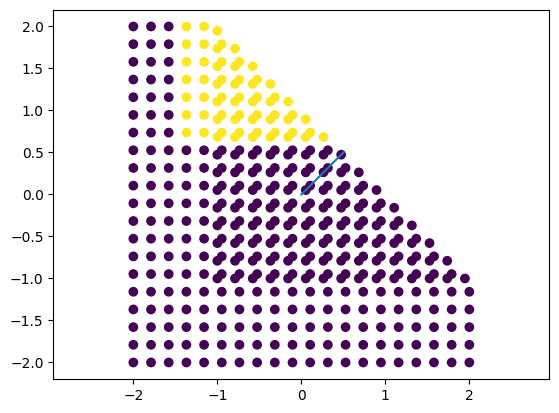

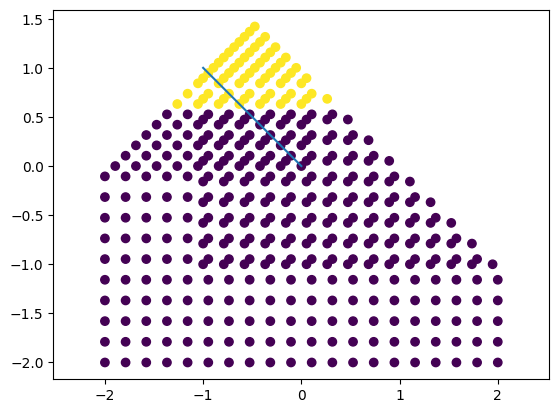

Epoch 236/1000:  24%|██▎       | 235/1000 [00:00<00:01, 398.69it/s]/Users/samlayton/Desktop/Work/Github/Open Source Repositories/FoldAndCutNetworks/model.py:259: RuntimeWarning: overflow encountered in exp
  sigmoid = 1/(1 + np.exp(-p))
/Users/samlayton/Desktop/Work/Github/Open Source Repositories/FoldAndCutNetworks/model.py:280: RuntimeWarning: overflow encountered in exp
  sigmoid = (1/(1 + np.exp(-p)))[:,np.newaxis, np.newaxis]
Epoch 1000/1000: 100%|██████████| 1000/1000 [00:02<00:00, 386.69it/s]


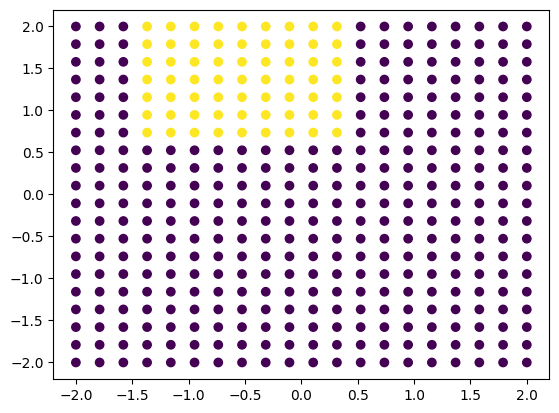

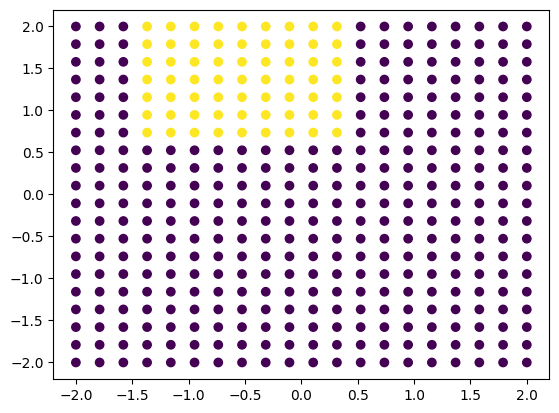

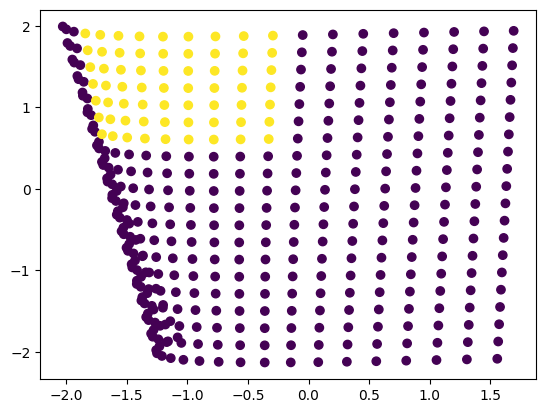

0.8725


In [34]:
layer = lambda D, n: D - 2 * np.outer((D@n)/np.dot(n, n), n)
crease = .5
# def layer(Z, n):
#     # Get the helpful terms to substitute into our fold function
#     z_dot_x = (Z@n)
#     n_dot_n = np.dot(n, n)
#     scales = z_dot_x / n_dot_n
#     p = crease * (z_dot_x - n_dot_n)
#     sigmoid = 1/(1 + np.exp(-p))
    
#     # Make the projection and flip the points that are beyond the fold
#     projected = np.outer(1-scales, n)
#     return Z + 2* sigmoid[:,np.newaxis] * projected


def layer(D, n):
    scales = (D@n)/np.dot(n, n)
    mask = scales > 1
    projected = 2 * np.outer(scales, n)
    adjustment = 2*n - projected
    return D + mask[:,np.newaxis] * adjustment

fv1 = .5*np.array([1,1])
fv2 = np.array([-1,1])

# make a meshgrid of x and y values
x1 = np.linspace(-2,2,20)
x2 = np.linspace(-2,2,20)
X1,X2 = np.meshgrid(x1,x2)

# reshape the meshgrid into a 2D array and concatenate them
X1 = X1.reshape(-1,1)
X2 = X2.reshape(-1,1)
pairs = np.concatenate((X1,X2),axis=1)
cut1 = layer(pairs, fv1)
cut2 = layer(cut1, fv2)
Y = cut2[:,1] > .6

plt.scatter(pairs[:,0],pairs[:,1], c = Y)
plt.axis('equal')
plt.show()

plt.scatter(cut1[:,0],cut1[:,1], c = Y)
plt.plot([0,fv1[0]],[0,fv1[1]])
plt.axis('equal')
plt.show()

plt.scatter(cut2[:,0],cut2[:,1], c = Y)
plt.plot([0,fv2[0]],[0,fv2[1]])
plt.axis('equal')
plt.show()


test = OrigamiNetwork(layers = 2, learning_rate=0.01, reg=0, optimizer="sgd", batch_size=32, epochs=1000, sigmoid=True, crease=.50)
test.fit(pairs,Y)
out = test.forward_pass(pairs)
for i in range(len(out)-1):
    plt.scatter(out[i][:,0],out[i][:,1], c = Y)
    # plt.plot([0,test.fold_vectors[i][0]],[0,test.fold_vectors[i][1]])
    plt.show()
    
print(accuracy_score(Y, test.predict(pairs)))

# test.back_propagation(np.arange(10))
# print(forward)
# print([(i, test.fold_vectors[i-1]) for i in range(test.layers, 0, -1)])
# [test.derivative_fold(forward[i], test.fold_vectors[i-1]) for i in range(test.layers, 0, -1)]

In [27]:

crease, width = 1.5, 2

def fold(Z, n):
    """
    This function folds the data along the hyperplane defined by the normal vector n
    
    Parameters:
        Z (n,d) ndarray - The data to fold
        n (d,) ndarray - The normal vector of the hyperplane
        leaky (float) - The amount of leak in the fold
    Returns:
        folded (n,d) ndarray - The folded data
    """
    # Make the scaled inner product and the mask
    scales = (Z@n)/np.dot(n, n)
    indicator = scales > 1

    # Make the projection and flip the points that are beyond the fold (mask)
    projected = np.outer(scales, n)
    folded = Z + 2 * indicator[:,np.newaxis] * (n - projected)
    return folded


def derivative_fold(Z, n):
    """
    This function calculates the derivative of the fold operation
    
    Parameters:
        Z (n,d) ndarray - The data to fold
        n (d,) ndarray - The normal vector of the hyperplane
        leaky (float) - The amount of leak in the fold
    Returns:
        derivative (n,d,d) ndarray - The derivative of the fold operation
    """
    # Get the scaled inner product, mask, and make the identity stack
    quad_normal = n / np.dot(n, n)
    scales = Z @ quad_normal
    indicator = scales > 1
    identity = np.eye(width)

    # Use broadcasting to apply scales along the first axis
    first_component = (1 - scales)[:, np.newaxis, np.newaxis] * identity
    
    # Calculate the outer product of n and helper, then subtract the input
    outer_product = np.outer(2 * scales, n) - Z
    second_component = np.einsum('ij,k->ijk', outer_product, quad_normal)
    
    # Return the derivative
    derivative = 2 * indicator[:,np.newaxis, np.newaxis] * (first_component + second_component)
    return derivative


def sig_fold(Z, n):
    """
    This function does a soft fold of the data along the hyperplane defined by the normal vector n
    Parameters:
        Z (n,d) ndarray - The data to fold
        n (d,) ndarray - The normal vector of the hyperplane
    Returns:
        folded (n,d) ndarray - The folded data
    """
    # Get the helpful terms to substitute into our fold function
    z_dot_x = (Z@n)
    n_dot_n = np.dot(n, n)
    scales = z_dot_x / n_dot_n
    p = crease * (z_dot_x - n_dot_n)
    sigmoid = 1/(1 + np.exp(-p))


    # Make the projection and flip the points that are beyond the fold
    projected = np.outer(1-scales, n)
    return Z + 2*sigmoid[:,np.newaxis] * projected


def sig_derivative_fold(Z, n):
    """
    This function calculates the derivative of the soft fold operation
    Parameters:
        Z (n,d) ndarray - The data to fold
        n (d,) ndarray - The normal vector of the hyperplane
    Returns:
        derivative (n,d,d) ndarray - The derivative of the fold operation
    """
    # Get the helpful terms to substitute into our derivative fold function
    z_dot_x = (Z@n)
    n_dot_n = np.dot(n, n)
    scales = z_dot_x / n_dot_n
    p = crease * (z_dot_x - n_dot_n)
    sigmoid = (1/(1 + np.exp(-p)))[:,np.newaxis, np.newaxis]
    u = n / n_dot_n
    identity_stack = np.stack([np.eye(width) for _ in range(len(Z))])
    one_minus_scales = 1 - scales[:,np.newaxis, np.newaxis]
        
    # Calculate the first component and the second, then combine them
    first_component = one_minus_scales * identity_stack
    second_component = np.einsum('ij,k->ijk', np.outer(2*Z@n, u) - Z, u)
    first_half = 2 * sigmoid * (first_component + second_component)
    
    # Calculate the second half of the derivative
    second_half = 2 * crease * one_minus_scales * sigmoid * (1-sigmoid) * np.einsum('ij,k->ijk', Z - 2*n[np.newaxis,:], n)
    return first_half + second_half


def test_diff(Z,n,eps, f, df):
    nudge1up = f(Z, fv1 + np.array([eps,0]))
    nudge1down = f(Z, fv1 - np.array([eps,0]))
    nudge2up = f(Z, fv1 + np.array([0,eps]))
    nudge2down = f(Z, fv1 - np.array([0,eps]))
    d1 = (nudge1up - nudge1down) / (2*eps)
    d2 = (nudge2up - nudge2down) / (2*eps)
    deriv = df(Z, n)
    autoderiv = np.zeros_like(deriv)
    autoderiv[:,0,:] = d1
    autoderiv[:,1,:] = d2
    return autoderiv, deriv


crease = 1.5
width = 2
autoderiv, deriv = test_diff(pairs, fv1, 1e-6, fold, derivative_fold)
print(np.allclose(autoderiv, deriv, atol=1e-12))
print(autoderiv - deriv)


True
[[[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]]

 ...

 [[-1.38475897e-10 -1.07021947e-10]
  [-2.60573785e-11 -5.75113290e-11]]

 [[ 1.30286892e-11 -1.07021947e-10]
  [-1.77561965e-10 -5.75113290e-11]]

 [[-2.79555934e-10 -3.29066552e-10]
  [ 1.15022658e-10  1.64533276e-10]]]
